In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
from validation.data import indeed_test_data, dot_train_data, get_soc_n

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 4]
plt.rcParams['savefig.dpi'] = 300

In [2]:
rel = lambda x: x/x.sum()

def format_bls(path):
    bls = pd.read_csv(path, sep='\t')
    bls = bls.dropna(subset = ['soc2000'])
    bls['soc3'] = bls['soc2000'].map(lambda x: str(int(x))[:3]).astype(int)
    bls = bls.rename(columns = { 'soc3': 'soc-3'})
    bls_dat = rel(bls.groupby('soc-3').sum().tot_emp)
    bls_dat = pd.DataFrame({'share': bls_dat})
    return bls_dat

def format_predicted(path):
    predictions = pd.read_csv(path)
    predicted_dat = rel(predictions.predicted_soc3.value_counts())
    df = pd.DataFrame(predicted_dat)
    df.index = df.index.rename('soc-3')
    return df.rename(columns = {'predicted_soc3': 'share'}).sort_values('soc-3')

def format_matched_dat(path, includes):
    matched = pd.read_csv(path)
    matched['soc3'] = get_soc_n(matched['2000 SOC code'], 3)
    matched_dat = rel(matched.soc3.value_counts()).reset_index()
    s = matched_dat.sort_values('index')
    matched_dat = s[s['index'].isin(includes)]
    return matched_dat.rename(columns = {'soc3': 'share', 'index': 'soc-3'}).set_index('soc-3')

In [3]:
bls_dat = format_bls('oes_2014_flat.csv')
matched_dat = format_matched_dat('indeed-us-titles-matched.csv', bls_dat.index)
predicted_dat = format_predicted('predictions/us-soc3-predictions.csv')

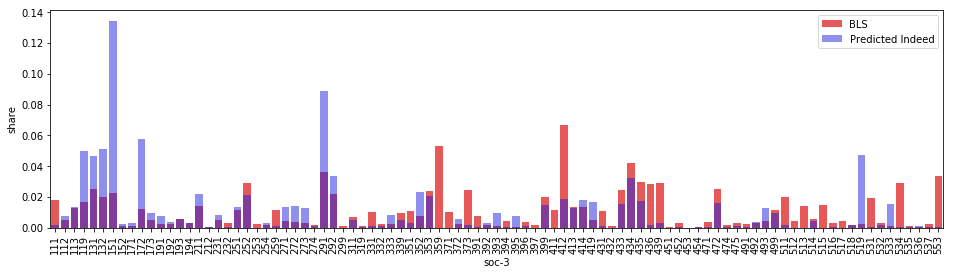

In [10]:
ax = sns.barplot(x='soc-3', y='share', color='red', alpha=.75, label='BLS', data=bls_dat.reset_index())
ax = sns.barplot(x='soc-3', y='share', ax=ax, color='blue', alpha=.5, label='Predicted Indeed', data=predicted_dat.reset_index())
ax.legend()
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.get_figure().savefig('figures/predicted-vs-BLS.png')

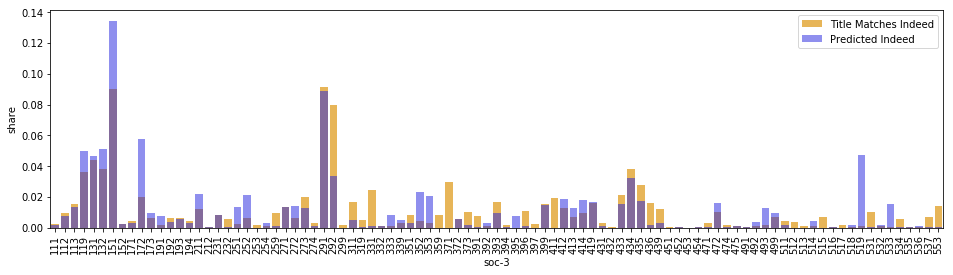

In [11]:
ax = sns.barplot(x='soc-3', y='share', color='orange', alpha=.75, label='Title Matches Indeed', data=matched_dat.reset_index())
ax = sns.barplot(x='soc-3', y='share', ax=ax, color='blue', alpha=.5, label='Predicted Indeed', data=predicted_dat.reset_index())
ax.legend()
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.get_figure().savefig('figures/predicted-vs-exact_match.png')

In [6]:
def plot_hist(dat):
    ax = sns.barplot(x = 'soc3', y='share', data = dat.reset_index())
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    return ax

In [7]:
d = pd.concat([bls_dat, matched_dat, predicted_dat], keys = ['BLS', 'Title Matches Indeed', 'Predicted Indeed']).reset_index().rename(columns = {'level_0': 'Source'})

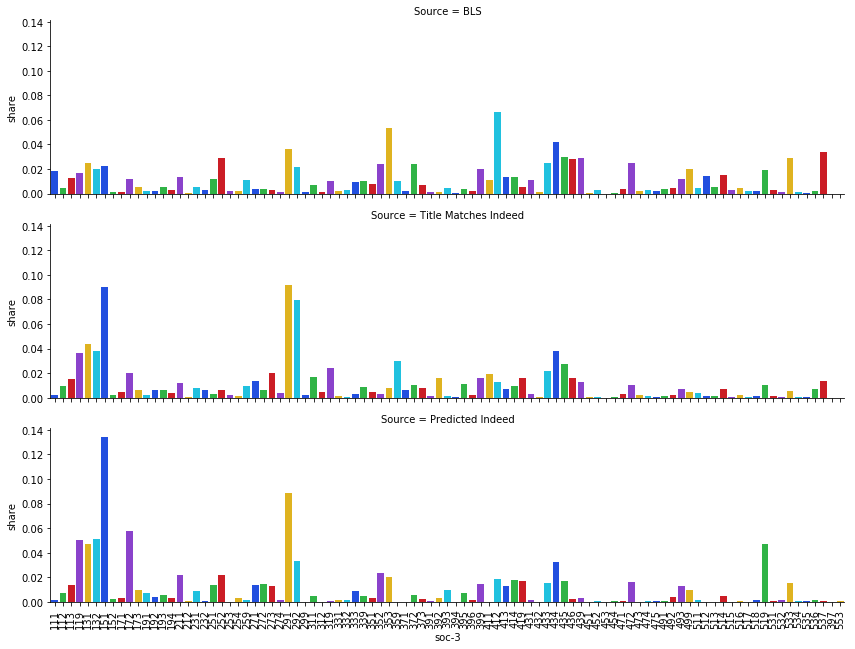

In [12]:
g = sns.FacetGrid(d, row='Source', aspect=4)
codes = d['soc-3'].unique()
ax = g.map(sns.barplot, 'soc-3', 'share', order = codes, palette=sns.palettes.color_palette('bright6', n_colors=len(codes)))
_ = ax.set_xticklabels(codes, rotation=90)
ax.savefig('figures/histograms-compared.png')

In [22]:
from scipy.stats import entropy

entropy(bls_dat.share, predicted_dat.share)

1.4813864556856637

In [ ]:
# get the multinomial distribution predicted for each datapoint
# sample (once) from that multinomial distribution for each datapoint
# repeat this sampling many times
# Those samples give you your posterior predictive of the labor distribution